```
# Introduction
```

**Optimizing search results, though an important component
of the internet and the web world, is relatively less
discussed in research and practice. Few scholars have
identified that search can be time and money consuming, and this can be appalling if users are unsuccessful in
obtaining desired results in the process. Research on personalized
search aggregation have also been used mainly
for marketing and business purpose. 






```
# Method
```

The common method
in the field is ranking users preference and matching output
that serves recommendation systems. However, single
user-independent ranking model are often insufficient
to satisfy different users’ result preferences. I propose a
transfer learning, the project creates word embeddings for
the universe of search queries and a model that assign labels
to new ones. This labels will be synchronized with
personalized and optimized search histories to give better
results for academic recommendations than standard
search engines. The search query data with COVID-19
intent will be used for this analysis.**

In [6]:
#Import libraries




## for data
import sklearn
import keras
import nltk
import pandas as pd
import numpy as np

## for processing
import re
import codecs
import nltk
import re
import pprint

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for w2v
import gensim
import gensim.downloader as gensim_api
## for bert
#import transformers

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [7]:
import gensim.downloader as api

word2vec= api.load('word2vec-google-news-300') #The gensim package has Word2Vec for word embedding and returning the most similar words for any given word into the vocabulary.


[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
jan = pd.read_csv("https://raw.githubusercontent.com/microsoft/BingCoronavirusQuerySet/master/data/2020/QueriesByState_2020-01-01_2020-01-31.tsv", sep='\t', header=0)

#feb = pd.read_csv("https://raw.githubusercontent.com/microsoft/BingCoronavirusQuerySet/master/data/2020/QueriesByCountry_2020-02-01_2020-02-29.tsv", sep='\t', header=0)

mar = pd.read_csv("https://raw.githubusercontent.com/microsoft/BingCoronavirusQuerySet/master/data/2020/QueriesByState_2020-03-01_2020-03-31.tsv", sep='\t', header=0)

apr = pd.read_csv("https://raw.githubusercontent.com/microsoft/BingCoronavirusQuerySet/master/data/2020/QueriesByState_2020-04-01_2020-04-30.tsv", sep='\t', header=0)

may = pd.read_csv("https://raw.githubusercontent.com/microsoft/BingCoronavirusQuerySet/master/data/2020/QueriesByState_2020-05-01_2020-05-31.tsv", sep='\t', header=0)

jun = pd.read_csv("https://raw.githubusercontent.com/microsoft/BingCoronavirusQuerySet/master/data/2020/QueriesByState_2020-06-01_2020-06-30.tsv", sep='\t', header=0)

#jul =pd.read_csv("https://raw.githubusercontent.com/microsoft/BingCoronavirusQuerySet/master/data/2020/QueriesByState_2020-07-01_2020-07-31.tsv", sep='\t', header=0)

#aug = pd.read_csv("https://raw.githubusercontent.com/microsoft/BingCoronavirusQuerySet/master/data/2020/QueriesByState_2020-08-01_2020-08-31.tsv", sep='\t', header=0)

#sep = pd.read_csv("https://raw.githubusercontent.com/microsoft/BingCoronavirusQuerySet/master/data/2020/QueriesByState_2020-09-01_2020-09-30.tsv", sep='\t', header=0)

#oct = pd.read_csv("https://raw.githubusercontent.com/microsoft/BingCoronavirusQuerySet/master/data/2020/QueriesByState_2020-10-01_2020-10-31.tsv", sep='\t', header=0)

#nov = pd.read_csv("https://raw.githubusercontent.com/microsoft/BingCoronavirusQuerySet/master/data/2020/QueriesByState_2020-11-01_2020-11-30.tsv", sep='\t', header=0)

#dec = pd.read_csv("https://raw.githubusercontent.com/microsoft/BingCoronavirusQuerySet/master/data/2020/QueriesByState_2020-12-01_2020-12-31.tsv", sep='\t', header=0)

#jan21= pd.read_csv("https://raw.githubusercontent.com/microsoft/BingCoronavirusQuerySet/master/data/2021/QueriesByState_2021-01-01_2021-01-31.tsv", sep='\t', header=0)


In [ ]:
df = pd.concat([jan, mar, apr, may, jun], ignore_index=True)


df.to_csv("df.csv")
df.head()


,Date,Query,IsImplicitIntent,State,Country,PopularityScore
0,2020-01-01,coronavirus,False,Michigan,United States,1
1,2020-01-01,coronavirus,False,Pennsylvania,United States,1
2,2020-01-01,p2 masks,True,Australian Capital Territory,Australia,1
3,2020-01-01,auswärtiges amt,True,North Rhine-Westphalia,Germany,1
4,2020-01-01,p2 masks,True,New South Wales,Australia,1


In [ ]:
print(df.sample(5))

              Date                        Query  ...        Country PopularityScore
29392   2020-01-29                 corona virus  ...  United States              14
138595  2020-03-05        tennessee coronavirus  ...  United States               1
257258  2020-03-10   coronavirus maine et loire  ...         France               1
710902  2020-03-20  self quarantine coronavirus  ...  United States               1
565092  2020-03-17                ncov2019.live  ...  United States               2

[5 rows x 6 columns]


# **Clean Data and Embed it into the Vector Space**

In [ ]:
def standardize_text(df, text_field):
      """clean data"""
      df[text_field] = df[text_field].str.replace(r"http\S+", "") #http matches literal characters \S+ matches all non-whitespace characters (the end of the url)
      df[text_field] = df[text_field].str.replace(r"http", "")#http matches literal characters
      df[text_field] = df[text_field].str.replace(r"@\S+", "") #matches all non-whitespace characters (the end of the url)
      df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ") #force the first letter to be alphabetic and the remaining characters to be 
      #alphanumeric or any of the following special characters:
      df[text_field] = df[text_field].str.replace(r"@", "at")
      df[text_field] = df[text_field].str.lower()
      df[text_field] = df[text_field].str.replace(r"[^a-zA-Z]", " ")# Search for all non-letters,  Replace all non-letters with spaces
      return df


In [ ]:
questions = standardize_text(df, "Query")

questions.to_csv("clean_data.csv")
questions.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


,Date,Query,IsImplicitIntent,State,Country,PopularityScore
0,2020-01-01,coronavirus,False,Michigan,United States,1
1,2020-01-01,coronavirus,False,Pennsylvania,United States,1
2,2020-01-01,p masks,True,Australian Capital Territory,Australia,1
3,2020-01-01,ausw rtiges amt,True,North Rhine-Westphalia,Germany,1
4,2020-01-01,p masks,True,New South Wales,Australia,1


In [ ]:
clean_questions1= pd.read_csv("clean_data.csv")
clean_questions1.tail()



,Unnamed: 0,Date,Query,IsImplicitIntent,State,Country,PopularityScore
2949623,2949623,2020-06-30,nzta,True,Waikato,New Zealand,1
2949624,2949624,2020-06-30,virginia coronavirus,False,Virginia,United States,46
2949625,2949625,2020-06-30,de morgen,True,Brussels Region,Belgium,26
2949626,2949626,2020-06-30,kdhe covid,False,Kansas,United States,2
2949627,2949627,2020-06-30,nationwide building society,True,Lanarkshire,United Kingdom,13


In [ ]:
clean_questions = clean_questions1.loc[clean_questions1.Query.str.contains("how", na=False)]

In [ ]:
clean_questions['Query']=clean_questions['Query'].apply(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
corpus = clean_questions.loc[(clean_questions.Country== "United States") & (clean_questions.Country== "United Kingdom")]

In [ ]:
from nltk.tokenize import RegexpTokenizer # A RegexpTokenizer splits a string into substrings using a regular expression.

tokenizer = RegexpTokenizer(r'\w+')

clean_questions["tokens"] = clean_questions['Query'].apply(tokenizer.tokenize)
clean_questions.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Unnamed: 0,Date,Query,IsImplicitIntent,State,Country,PopularityScore,tokens
8347,8347,2020-01-24,how did the coronavirus start,False,Texas,United States,1,"[how, did, the, coronavirus, start]"
9111,9111,2020-01-24,how is coronavirus spread,False,New York,United States,1,"[how, is, coronavirus, spread]"
9116,9116,2020-01-24,how is the coronavirus transmitted,False,New York,United States,1,"[how, is, the, coronavirus, transmitted]"
9346,9346,2020-01-24,how is coronavirus spread,False,Illinois,United States,1,"[how, is, coronavirus, spread]"
9356,9356,2020-01-24,how is coronavirus transmitted,False,Illinois,United States,1,"[how, is, coronavirus, transmitted]"


In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

all_words = [word for tokens in clean_questions["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

NameError: ignored

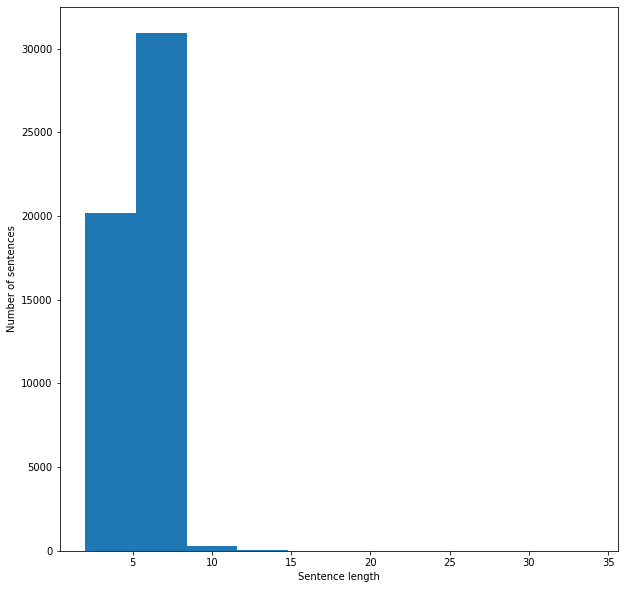

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    Tfidf_vectorizer = TfidfVectorizer()

    emb = Tfidf_vectorizer.fit_transform(data)

    return emb, Tfidf_vectorizer

list_corpus = clean_questions["Query"].tolist()
list_labels = clean_questions["IsImplicitIntent"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, Tfidf_vectorizer = cv(X_train)
X_test_counts = Tfidf_vectorizer.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', 
                         #n_jobs=-1,
                         random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

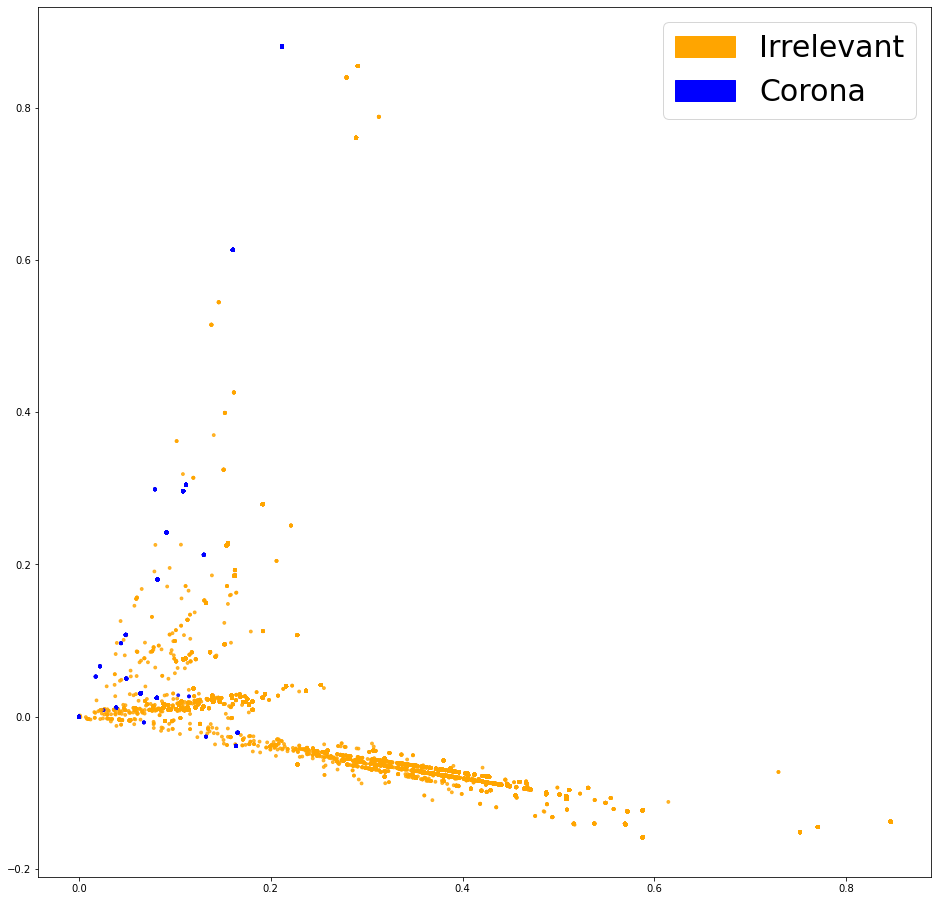

In [ ]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Corona')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()


In [ ]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

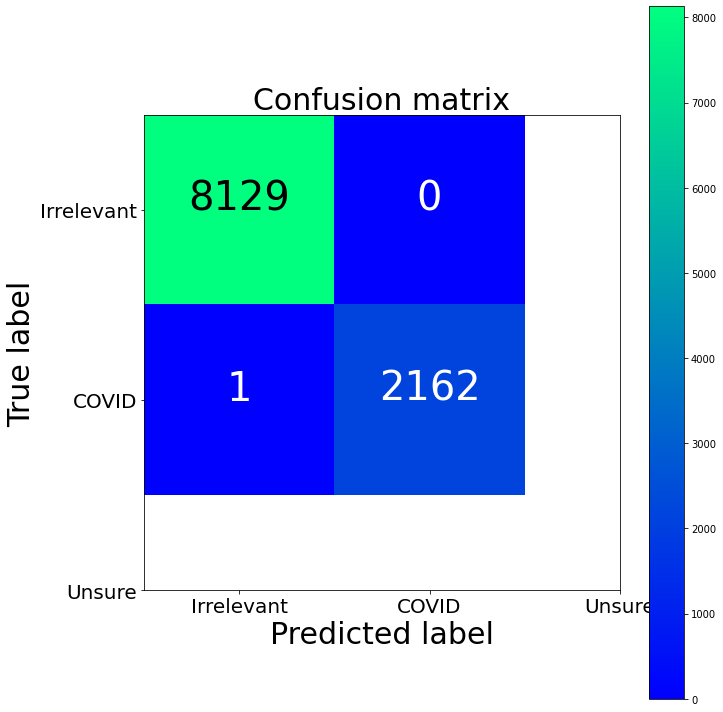

[[8129    0]
 [   1 2162]]


In [ ]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','COVID','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

In [ ]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[-n:], key = lambda x : x[0])
        bottom = sorted_coeff[:n]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(Tfidf_vectorizer, clf, 15)

In [ ]:
importance


{0: {'bottom': [(5.502266189580958, 'unemployment'),
   (4.265551931868567, 'lockdown'),
   (3.797783846448928, 'flu'),
   (3.7205852756478563, 'to'),
   (3.540845724089874, 'check'),
   (3.288088229978159, 'stimulus'),
   (3.258524613693463, 'apply'),
   (2.909784352803488, 'die'),
   (2.8942064868523403, 'file'),
   (2.876451364840668, 'closed'),
   (2.813923344014836, 'hand'),
   (2.813923344014836, 'sanitizer'),
   (2.7631700660240415, 'browne'),
   (2.7631700660240415, 'rodney'),
   (2.6139153204802725, 'schools')],
  'tops': [(-26.955124532514922, 'coronavirus'),
   (-5.8095265878602005, 'covid'),
   (-5.630802591519913, 'corona'),
   (-2.550986901069695, 'for'),
   (-2.410087829247664, 'due'),
   (-2.2638232483939404, 'in'),
   (-2.102405804966886, 'corna'),
   (-1.745713488845286, 'cases'),
   (-1.7310631823547429, 'from'),
   (-1.5902564160240054, 'survive'),
   (-1.5190779282256188, 'of'),
   (-1.511560446430542, 'does'),
   (-1.418605810340414, 'objects'),
   (-1.29329673618

In [ ]:
  def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Relevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()



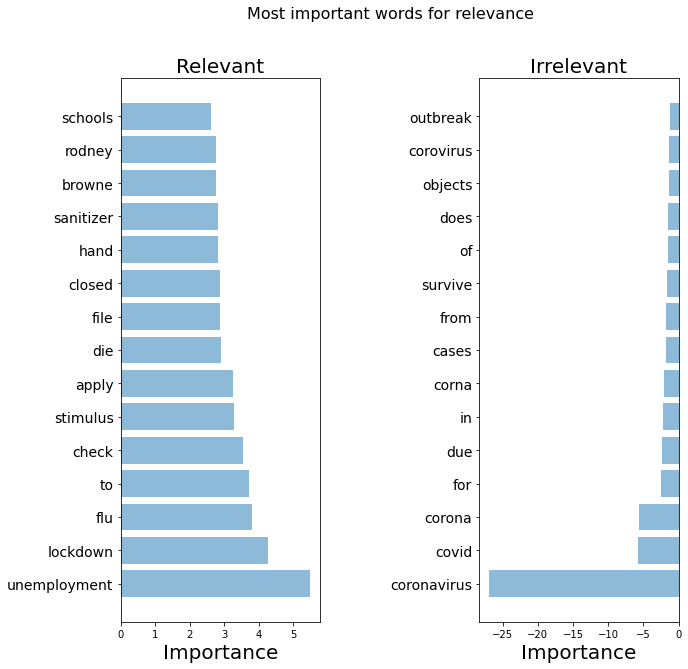

In [ ]:
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

In [ ]:
#define vocab
from collections import Counter
vocab = Counter()

min_occurane = 2
tokens = [k for k,c in vocab.items() if c >= min_occurane]
print(len(clean_questions['tokens']))

51456


In [ ]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

**embedding search query **

In [ ]:
#embeddings = get_word2vec_embeddings(word2vec, clean_questions)
#X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, 
                                                                                        test_size=0.2, random_state=40)

IndentationError: ignored

In [ ]:
embeddings = get_word2vec_embeddings(word2vec, clean_questions)



**embedding news data **

In [ ]:
import os
import tweepy as tw
import pandas as pd
import tweepy,json

In [ ]:
consumer_key= '9En7QwfhJFUqf1fhB5PVJWFJi'
consumer_secret= 'XRWNvplvNJFqN9M3AazJg08ZSBjIENWu89REOYEcC2t4upeW4L'
access_token= '163970342-mNyvv6VFWenF0HhkhuJQONR261pC7y28ptMhQrL4'
access_token_secret= 'qZS29RsdrXhSeuou5yrU1jh3op9b6YWDFkBFSPzPXETaa'

auth= tweepy.OAuthHandler(consumer_key,consumer_secret)
auth.set_access_token(access_token,access_token_secret)

In [ ]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [ ]:
# Define the search term and the date_since date as variables
search_words= "coronavirus OR covid OR corona OR covid19 OR facemask OR sanitizer OR social-distancing -filter:retweets"
date_since = "2022-01-01"

In [ ]:
# Define the search term and the date_since date as variables
search_words= "died from the corona virus -filter:retweets"
date_since = "2021-01-01"

In [ ]:
# Collect tweets
tweets = tw.Cursor(api.search,
                       q=search_words,
                       lang="en",
                      
                       since=date_since).items(5)

# Collect a list of tweets
tweett =[tweet.text for tweet in tweets]



In [ ]:
tweets = tw.Cursor(api.search, 
                           q=search_words,
                           lang="en",
                           since=date_since).items(1000)

tweett = [[tweet.user.screen_name, tweet.user.location, tweet.created_at, tweet.text] for tweet in tweets]


In [ ]:
tweet_text = pd.DataFrame(data=tweett, 
                    columns=['user', 'location', 'date', 'text'])



tweet_text

,user,location,date,text
0,Bigbird32392741,,2022-02-26 03:11:32,@james_mc_carthy @lux_schwab @RitaPanahi @Mart...
1,ImmanuelGlory,,2022-02-26 02:09:22,@i_nivethathomas No corona virus for god's chi...
2,anon20421494,,2022-02-25 19:27:22,@logosaetos @5_News @catherine5news but don't ...
3,DrrightrdBob,"Toronto, Ont., CND. - U.N. OUT",2022-02-25 17:00:17,"Since 2019, just under 35K died from the Chine..."
4,MyDream31151832,"Kolkata, India",2022-02-25 06:13:22,Not war now. Now is not the time to fight. The...
5,1Kushalbaral,"San Francisco, CA",2022-02-24 21:38:09,"According to the Johns Hopkins University, USA..."
6,abdulbasit03441,United Kingdom,2022-02-23 12:33:29,@haiderbaloch100 @MaidahMuhammad I am a doctor...
7,rk70534,Finland,2022-02-22 23:12:41,8 of the victims who died of the virus were fr...
8,ArianaCherelle,,2022-02-22 13:38:04,@JXownie @Bambiey57428487 @v0quex @bignarstie ...
9,NewblyEnglishAT,Austria,2022-02-22 03:05:30,German study confirms: Most Corona deaths died...


In [ ]:
 from pandas import Series
  
#tweet_text['text'].str.split('((?:<a href=")?https?://\S+[^\s,.:;])').apply(Series, 1).stack()
def faster(df):
    s = tweet_text['text'].str.split('((?:<a href=")?https?://\S+[^\s,.:;])', expand=True).stack()
    i = s.index.get_level_values(0)
    df2 = df.loc[i].copy()
    df2["link"] = s.values
    return df2

new=faster(tweet_text)
new
tweet_text1=new[new['link'].str.contains("https")]
tweet_text1 = standardize_text(tweet_text1, "text")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_l

In [ ]:

tweet_text1

,user,location,date,text,link
0,Bigbird32392741,,2022-02-26 03:11:32,lying ok what does with corona virus mean ...,https://t.co/F2j6iEJyOx
1,ImmanuelGlory,,2022-02-26 02:09:22,no corona virus for god s children god bles...,https://t.co/iQp9GR2SXB
2,anon20421494,,2022-02-25 19:27:22,but don t worry we saved some coffin dodge...,https://t.co/Wbgxzh8Y6N
3,DrrightrdBob,"Toronto, Ont., CND. - U.N. OUT",2022-02-25 17:00:17,since just under k died from the chine...,https://t.co/IaPItZfDKc
4,MyDream31151832,"Kolkata, India",2022-02-25 06:13:22,not war now now is not the time to fight the...,https://t.co/IZq9T9EvaD
5,1Kushalbaral,"San Francisco, CA",2022-02-24 21:38:09,according to the johns hopkins university usa...,https://t.co/ggbJ9083pR
6,abdulbasit03441,United Kingdom,2022-02-23 12:33:29,i am a doctor too i know vaccines ready o...,https://t.co/dsugJ4jY9c
7,rk70534,Finland,2022-02-22 23:12:41,of the victims who died of the virus were fr...,https://t.co/HbDIO0C0SY
8,ArianaCherelle,,2022-02-22 13:38:04,please show your evidence of a young fit ...,https://t.co/qk13AsZtpT
9,NewblyEnglishAT,Austria,2022-02-22 03:05:30,german study confirms most corona deaths died...,https://t.co/YNPOIKXdbQ


In [ ]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

tweet_text1 ["tokens"] = tweet_text1 ["text"].apply(tokenizer.tokenize)

tweet_text1 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,user,location,date,text,link,tokens
0,Bigbird32392741,,2022-02-26 03:11:32,lying ok what does with corona virus mean ...,https://t.co/F2j6iEJyOx,"[lying, ok, what, does, with, corona, virus, m..."
1,ImmanuelGlory,,2022-02-26 02:09:22,no corona virus for god s children god bles...,https://t.co/iQp9GR2SXB,"[no, corona, virus, for, god, s, children, god..."
2,anon20421494,,2022-02-25 19:27:22,but don t worry we saved some coffin dodge...,https://t.co/Wbgxzh8Y6N,"[but, don, t, worry, we, saved, some, coffin, ..."
3,DrrightrdBob,"Toronto, Ont., CND. - U.N. OUT",2022-02-25 17:00:17,since just under k died from the chine...,https://t.co/IaPItZfDKc,"[since, just, under, k, died, from, the, chine..."
4,MyDream31151832,"Kolkata, India",2022-02-25 06:13:22,not war now now is not the time to fight the...,https://t.co/IZq9T9EvaD,"[not, war, now, now, is, not, the, time, to, f..."
5,1Kushalbaral,"San Francisco, CA",2022-02-24 21:38:09,according to the johns hopkins university usa...,https://t.co/ggbJ9083pR,"[according, to, the, johns, hopkins, universit..."
6,abdulbasit03441,United Kingdom,2022-02-23 12:33:29,i am a doctor too i know vaccines ready o...,https://t.co/dsugJ4jY9c,"[i, am, a, doctor, too, i, know, vaccines, rea..."
7,rk70534,Finland,2022-02-22 23:12:41,of the victims who died of the virus were fr...,https://t.co/HbDIO0C0SY,"[of, the, victims, who, died, of, the, virus, ..."
8,ArianaCherelle,,2022-02-22 13:38:04,please show your evidence of a young fit ...,https://t.co/qk13AsZtpT,"[please, show, your, evidence, of, a, young, f..."
9,NewblyEnglishAT,Austria,2022-02-22 03:05:30,german study confirms most corona deaths died...,https://t.co/YNPOIKXdbQ,"[german, study, confirms, most, corona, deaths..."


**bold text** embedding both data

In [ ]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged


def get_word2vec_embeddings1(vectors, mediuim_df, generate_missing=False):
    embeddings1 = mediuim_df['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings1)

In [ ]:
embeddings2= get_word2vec_embeddings1(word2vec, tweet_text1)
#embeddings2

In [ ]:
from scipy.spatial.distance import cosine

# Calculating the distance between the
# embeddings of 'bank' in all the
# given contexts of the word

list_of_distances = []
for text1, embed1 in zip(clean_questions["Query"], embeddings):
    for text2, embed2, link in zip(tweet_text1['text'], embeddings2, tweet_text1["link"]):
        cos_dist =1- cosine(embed1, embed2)
      
        list_of_distances.append([text1, text2, cos_dist, link])

distances_df = pd.DataFrame(list_of_distances, columns=['text1', 'text2', 'distance', "link"]).dropna()
diss = distances_df.sort_values(
     by="distance",
     ascending=False
 )


diss

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


,text1,text2,distance,link
76203,how many people have died from the corona virus,since just under k died from the chine...,0.822817,https://t.co/IaPItZfDKc
1683,how many people have died from the corona virus,since just under k died from the chine...,0.822817,https://t.co/IaPItZfDKc
693153,how many have died in new york with the corona...,since just under k died from the chine...,0.819601,https://t.co/IaPItZfDKc
246513,how many people died in italy of corona virus,since just under k died from the chine...,0.810024,https://t.co/IaPItZfDKc
172638,how many people died in italy of corona virus,since just under k died from the chine...,0.810024,https://t.co/IaPItZfDKc
...,...,...,...,...
679319,howard county md coronavirus,tell that to the children of my cousin who...,0.139566,https://t.co/Fg72OfbpQS
160034,howard county md coronavirus,tell that to the children of my cousin who...,0.139566,https://t.co/Fg72OfbpQS
700109,howard county md coronavirus,tell that to the children of my cousin who...,0.139566,https://t.co/Fg72OfbpQS
47792,eisenhower corona virus,but don t worry we saved some coffin dodge...,0.137504,https://t.co/Wbgxzh8Y6N


In [ ]:
result_df = diss.drop_duplicates(subset='text2')
result_df

,text1,text2,distance,link
76203,how many people have died from the corona virus,since just under k died from the chine...,0.822817,https://t.co/IaPItZfDKc
76211,how many people have died from the corona virus,yup only of the total deaths died from c...,0.803076,https://t.co/hEQga0odIM
162339,how many deaths in canada from corona virus,german study confirms most corona deaths died...,0.802489,https://t.co/YNPOIKXdbQ
12793,how do you know if you have the coronavirus,im sorry if someone from your family died of c...,0.793847,https://t.co/rmxSbb7tTT
231015,once you have corona virus symptoms how long d...,lying ok what does with corona virus mean ...,0.776315,https://t.co/F2j6iEJyOx
246515,how many people died in italy of corona virus,according to the johns hopkins university usa...,0.773724,https://t.co/ggbJ9083pR
208489,how long has it been since china started the c...,not war now now is not the time to fight the...,0.772729,https://t.co/IZq9T9EvaD
247405,how to talk to your kids about the corona virus,page of q do you know why the corona ...,0.768251,https://t.co/By7e7mnwil
659594,how many people have died from coronovirus,tell that to the children of my cousin who...,0.761702,https://t.co/Fg72OfbpQS
242976,how do i know if i have coronavirus,i am a doctor too i know vaccines ready o...,0.738260,https://t.co/dsugJ4jY9c


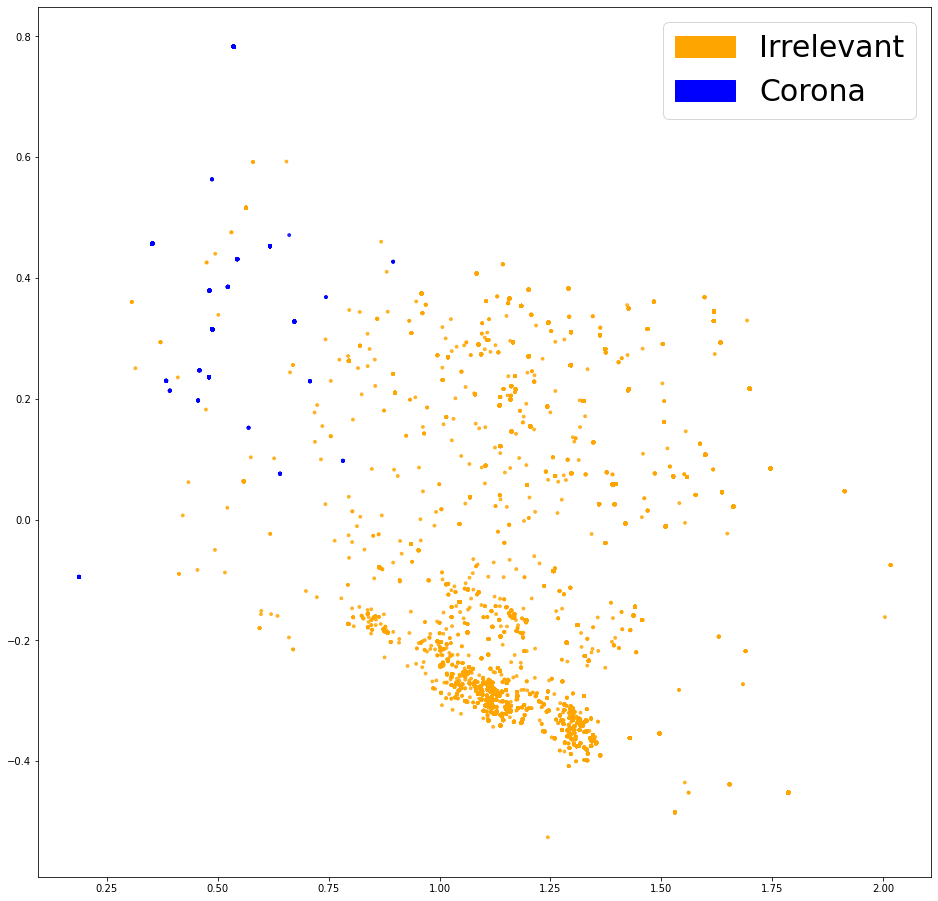

In [ ]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(embeddings, list_labels)
plt.show()